# Exercise 6.4: Geometric Deep Learning (GDL)

Advanced Machine Learning for KCS

by Stefan Heinrich, Stella Grasshof, Laura Weihl, Noah Brunken Syrkis 
with material by Kevin Murphy,

This notebook is based on material by Emanuele Rodolà, Luca Moschella, and Antonio Norelli.

All info and static material: https://learnit.itu.dk/course/view.php?id=3021295

-------------------------------------------------------------------------------

*Note: the notebook includes a huge amount of code! You are not supposed to understand it all, but follow the questions from the tasks and the inline hints closely.*

In [4]:
# @title #### import dependencies
from __future__ import print_function, division

#!sudo pip install python-igraph
#!sudo pip install plotly

from IPython.display import HTML

from typing import Mapping, Union, Optional, List
from pathlib import Path

import os
import math
import pickle
import numpy as np
import argparse

import torch
import torch.nn as nn
from torch.nn import Module
import torch.nn.functional as F
import torch.optim as optim

import networkx as nx
from sklearn.metrics import classification_report

import plotly as py
import plotly.graph_objects as go
import plotly.express as px
import igraph
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torchvision
from torchvision import datasets, models, transforms

from tqdm.notebook import tqdm
from tqdm import trange

In [5]:
# @title #### for reproducibility
# Whenever we use randomness, we should make sure that our results are still reproducible, so we use fixed random seeds.

import random
np.random.seed(4)
random.seed(4)

torch.cuda.manual_seed(4)
torch.manual_seed(4)
torch.backends.cudnn.deterministic = True  # Note that this Deterministic mode can have a performance impact
torch.backends.cudnn.benchmark = False

### Introduction: Digesting *a priori* the information in the structure 

We have already learned how to consider the structure information in a simple case; when the domain $\Omega$ is the Euclidean $\mathbb{R}^2$, i.e. when the relations between variables are represented by a 2-dimensional grid, such as the pixels of an image.

![immagine griglia 2d](https://raw.githubusercontent.com/lucmos/DLAI-s2-2020-tutorials/master/09/pics/euclidean.PNG) 

The filters of a convolutional neural network elaborate pixels considering only their neighbors and are applied with the same weights all over the image. In this way **CNNs are digesting *a priori* the structure information**, using the properties of the domain -- the translational invariance and the locality of neighbours -- to **reduce the free parameters of the model**. This leads to a crucial speed-up of the training process and allows larger and more powerful models. 

CNNs can be naturally extended to general Euclidean domains $\mathbb{R}^n$, but what can we do when $\Omega \neq \mathbb{R}^n$?

In many different fields such as Biology, Physics, Social Sciences and Computer Graphics we have to process signals defined on non-Euclidean domains, such as Graphs $\Omega = G(\mathcal{V, E})$ or [Manifolds](https://en.wikipedia.org/wiki/Manifold) $\Omega = \mathcal{X}$, where $\mathcal{V} = \left\{1,2,\dots,n\right\}$ are vertices or nodes and $\mathcal{E}\subseteq \mathcal{V}\times \mathcal{V}$ are edges or connections.

We would like to come out with a solution analoguous to CNNs; digesting *a priori* the structure information to reduce the free parameters proved to be very convenient in a learning setting based on a gradient descent optimization.


##### Representing non-Euclidean data in an Euclidean memory

Working with non-Euclidean domains provides a further challenge in representing the data. 

In the Euclidean setting, encoding the data in ordered matrices, vectors or tensors is so natural and effective that we do not even think to alternatives, and indeed the computer memory structure is itself Euclidean.

In the non-Euclidean setting we have many alternatives, consider for instance a manifold $\mathcal{X}$. It can be represented by a triangle mesh with vertices, edges and faces $\mathcal{V,E,F}$, by a n-polygonal mesh, where we admit also non-triangle faces, by a simple point cloud or by a subdivision surface. 

And even when we have chosen the representation, we still have to come out with a last encoding procedure to store our data in matrices and tensors as required by the Euclidean structure of the physical memory in our computers. Is it always going to be this way? Maybe one day we will have new pieces of hardware structured as graphs, like human brains.


### Graph Convolutional Networks (GCN or ConvGNN) on the Karate Dataset

In this section we will see the GCN as defined in the paper [Semi-Supervised Classification with Graph Convolutional Networks](https://arxiv.org/abs/1609.02907), applied to the [Karate dataset](http://networkrepository.com/soc-karate.php), Code and explanations are adapted from this [tutorial](https://nbviewer.org/github/vistalab-technion/cs236781-tutorials/blob/master/t10/tutorial10-GeometricDL.ipynb).

#### The Karate dataset

The Karate dataset is a very small graph with only 34 nodes, the task we will tackle is node classification.

This small dataset will allow us to visualize the graph and the behaviour of the graph convolution.

From [Wikipedia](https://en.wikipedia.org/wiki/Zachary%27s_karate_club),

> A social network of a karate club was studied by Wayne W. Zachary for a period of three years from 1970 to 1972.
> The network captures 34 members of a karate club, documenting links between pairs of members who **interacted outside the club**.
> During the study a conflict arose between the **administrator** "John A" and **instructor** "Mr. Hi" (pseudonyms), which led to the split of the club into two.
> 
> Half of the members formed a new club around Mr. Hi; members from the other part found a new instructor or gave up karate. Based on collected data Zachary correctly assigned all but one member of the club to the groups they actually joined after the split. 
> 

That is,

- Each node is a member of the club
- A link means that two members have interacted outside the club
- Every node has an attribute `club` that indicates which of the two communities he joined after the split.

Our goal is to detected which members of the splitted club will join either of the two splitted communities. 

**We will use the labels of only two nodes**, and infer the labels of all the other nodes from the graph structure.

In [6]:
# The karate dataset is built-in in networkx package, that we imported above

G = nx.karate_club_graph()

# Known ids of the instructor, admin and members
ID_INSTR = 0    
ID_ADMIN = 33
ID_MEMBERS = set(G.nodes()) - {ID_ADMIN, ID_INSTR}

print(f'{G.name}: {len(G.nodes)} vertices, {len(G.edges)} edges')

Zachary's Karate Club: 34 vertices, 78 edges


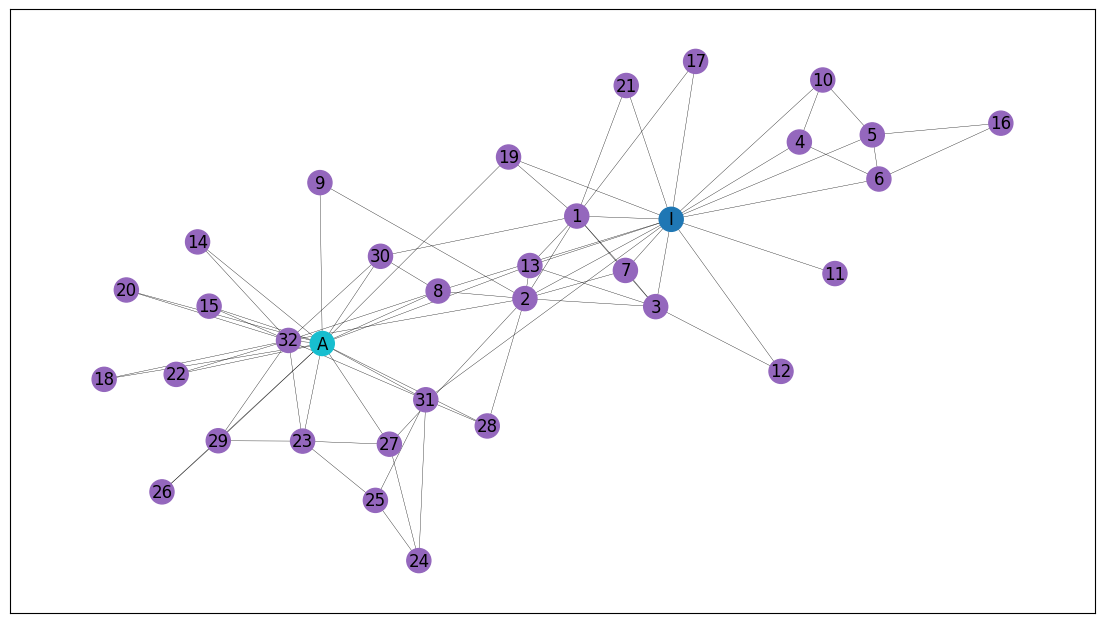

In [7]:
#@title ##### Visualization
# Visualize the Karate Club graph using network x
fig, ax = plt.subplots(1,1, figsize=(14,8), dpi=100)
pos = nx.spring_layout(G, iterations=500)
cmap = cmap=plt.cm.tab10
node_colors = [0.4] * G.number_of_nodes()
node_colors[ID_INSTR] = 0.
node_colors[ID_ADMIN] = 1.
node_labels = {i: i for i in ID_MEMBERS}
node_labels.update({i: l for i,l in zip([ID_ADMIN, ID_INSTR],['A','I'])})
nx.draw_networkx(G, 
                 pos, 
                 node_color=node_colors, 
                 width=.25,
                 labels=node_labels, 
                 ax=ax, 
                 cmap=cmap);

Looking at the graph, it looks like there are two communities around the instructor and the administrator. 

It is intuitive to assume the members close to the instructor will join the community of the instructor when the club will split, and the same with the administrator. Even though, for some nodes it is not obvious even for us to predict which cummunity they will join.

The graph neural networks are able to *learn* effectively from the *structure* of the graph, and make predictions according to it.

#### Data preprocessing

Thus, to recap, we're going to use only two labels and perform the prediction on the other nodes looking only at the graph structure.

Each vertex has a `club` attribute to represent the post-split community he joined, we will train using the `club` labels for the Instructor and the Administrator only.

For the other nodes we will just use a one-hot encoding, that are *not informative* on which community that node will join. Thus the model will have to learn everything from the structure.

In [8]:
# Input featuers (no information on nodes):
X = torch.eye(G.number_of_nodes())

# Create ground-truth labels
# - Assign the label "0" to the "Mr. Hi" community
# - Assign the label "1" to the "Officer" community
labels = [int(not d['club']=='Mr. Hi') for _, d in G.nodes().data()]
labels = torch.tensor(labels, dtype=torch.long)

# Let's check the nodes metadata
for (node_id, node_data), label_id in zip(G.nodes().data(), labels):
    print(f'Node id: {node_id},\tClub: {node_data["club"]},\t\tLabel: {label_id.item()}')

Node id: 0,	Club: Mr. Hi,		Label: 0
Node id: 1,	Club: Mr. Hi,		Label: 0
Node id: 2,	Club: Mr. Hi,		Label: 0
Node id: 3,	Club: Mr. Hi,		Label: 0
Node id: 4,	Club: Mr. Hi,		Label: 0
Node id: 5,	Club: Mr. Hi,		Label: 0
Node id: 6,	Club: Mr. Hi,		Label: 0
Node id: 7,	Club: Mr. Hi,		Label: 0
Node id: 8,	Club: Mr. Hi,		Label: 0
Node id: 9,	Club: Officer,		Label: 1
Node id: 10,	Club: Mr. Hi,		Label: 0
Node id: 11,	Club: Mr. Hi,		Label: 0
Node id: 12,	Club: Mr. Hi,		Label: 0
Node id: 13,	Club: Mr. Hi,		Label: 0
Node id: 14,	Club: Officer,		Label: 1
Node id: 15,	Club: Officer,		Label: 1
Node id: 16,	Club: Mr. Hi,		Label: 0
Node id: 17,	Club: Mr. Hi,		Label: 0
Node id: 18,	Club: Officer,		Label: 1
Node id: 19,	Club: Mr. Hi,		Label: 0
Node id: 20,	Club: Officer,		Label: 1
Node id: 21,	Club: Mr. Hi,		Label: 0
Node id: 22,	Club: Officer,		Label: 1
Node id: 23,	Club: Officer,		Label: 1
Node id: 24,	Club: Officer,		Label: 1
Node id: 25,	Club: Officer,		Label: 1
Node id: 26,	Club: Officer,		Label: 1
N

##### Adjacency matrices as operators

We can see *node-to-node* adjacency matrices as *operators* when applied to functions over the vertices of a graph.

For example, $\mathbf{g} = \mathbf{Af}$ yields a new *node-based* function $g$ defined as:

$$
g(v_i) = \sum_{e_{ij} \in E} f(v_j)
$$

On this observation, one can construct new adjacency-based operators such as $\mathbf{I-A}$:

$$
g(v_i) = f(v_i) - \sum_{e_{ij} \in E} f(v_j)
$$

Or such as... the Laplacian operator

-------------------------------------------------------------------------------
#### **Task**
Understand how we represent the task for the GCN and in particular, the node-to-node operators.

  - What does the $k$-power of the adjacency matrix $A$ represent?
  - I.e. what does the element $(A^k)_{ij}$ represent? 
-------------------------------------------------------------------------------

#### Graph Laplacian

##### Laplacian computation

The Graph Laplacian is defined as follows:

$$
L_{ij} =
\begin{cases}
 D_{ii} & \text{if } i = j \\
 -1 & \text{if } i \neq j \text{ and } e_{ij} \in E \\
 0 & \text{otherwise}
\end{cases}
$$

where $D$ is the diagonal matrix that contains the degree of the vertices $v_i$ along the diagonal.

Thus, the laplacian can be written in matrix notation as:

$$
L = D - A
$$

The Laplacian can be seen as a vertex-based operator, it is a function $f: V \to \mathcal{R}$

In [9]:
# Adjacency matrix, binary
A = nx.adj_matrix(G, weight=None)
A = np.array(A.todense())
A

/var/folders/gr/v_6cxqhs7m5d538mpxzczl140000gn/T/ipykernel_80125/1063595322.py:2: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  A = nx.adj_matrix(G, weight=None)
/Users/martinholst/miniconda3/envs/AML/lib/python3.10/site-packages/networkx/linalg/graphmatrix.py:187: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return adjacency_matrix(G, nodelist, dtype, weight)


array([[0, 1, 1, ..., 1, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 1, 0],
       ...,
       [1, 0, 0, ..., 0, 1, 1],
       [0, 0, 1, ..., 1, 0, 1],
       [0, 0, 0, ..., 1, 1, 0]])

In [10]:
# Degree matrix
dii = np.sum(A, axis=1, keepdims=False)  # sum the columns of the adj
D = np.diag(dii)
D

array([[16,  0,  0, ...,  0,  0,  0],
       [ 0,  9,  0, ...,  0,  0,  0],
       [ 0,  0, 10, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  6,  0,  0],
       [ 0,  0,  0, ...,  0, 12,  0],
       [ 0,  0,  0, ...,  0,  0, 17]])

In [11]:
# Laplacian
L = D - A
L

array([[16, -1, -1, ..., -1,  0,  0],
       [-1,  9, -1, ...,  0,  0,  0],
       [-1, -1, 10, ...,  0, -1,  0],
       ...,
       [-1,  0,  0, ...,  6, -1, -1],
       [ 0,  0, -1, ..., -1, 12, -1],
       [ 0,  0,  0, ..., -1, -1, 17]])

##### The Laplacian matrix has some interesting properties

The Laplacian $L$ of an undirected graph has many interesting properties, some of them are:

- It is symmetric and has the same zero pattern of the adjacency matrix
- It is [positive-semidefinite](https://en.wikipedia.org/wiki/Definiteness_of_a_matrix)
- Every row sum and column sum of $L$ is zero.
- The trace of the Laplacian Matrix $L$ is equal to $2m$ where $m$ is the number of edges of the considered graph. (This is straighforward to prove: the sum of the degrees of the vertices is twice the number of the edges. Why? Each edge connects exactly two vertices. Thus, it is counted twice in the sum of degrees, once for each vertex it connects.)
- For a graph with multiple connected components, $L$ is a block diagonal matrix (possibly after reordering the vertices), where each block is the Laplacian matrix of each component.

In [12]:
# Symmetric
(L.transpose() == L).all()


True

In [13]:
# Sum of degrees
np.trace(L) == 2 * G.number_of_edges()

True

In [14]:
# Sum of colums/rows is zero
print(np.sum(L, axis=1))
print(np.sum(L, axis=0))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


##### The Laplacian spectrum

As you already saw, the eigenfunctions of the Laplacian operator are a generalization of the Fourier basis, which we can use as a basis to represent functions over our domain.

Even the spectrum, i.e. the eigenvalues of the Laplacian, have many interesting properties. Some of them are:

- The first eigenvalue is always zero
- The number of connected components in the graph is the multiplicity of the zero eigenvalue






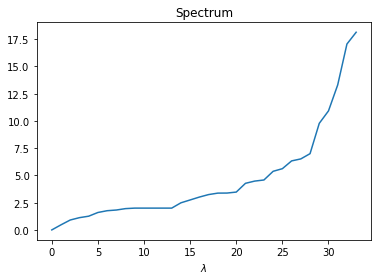

In [15]:
# Compute the eigevanlues and eigenvector
w, Phi = np.linalg.eigh(L)

plt.plot(w); plt.xlabel(r'$\lambda$'); plt.title('Spectrum');

##### Laplacian basis

Let's visualize the Laplacian basis of the Karate graph, we expect an oscillatory behaviour similar to the Fourier basis on signals. 

It will be a bit difficult to see, since there are few nodes.

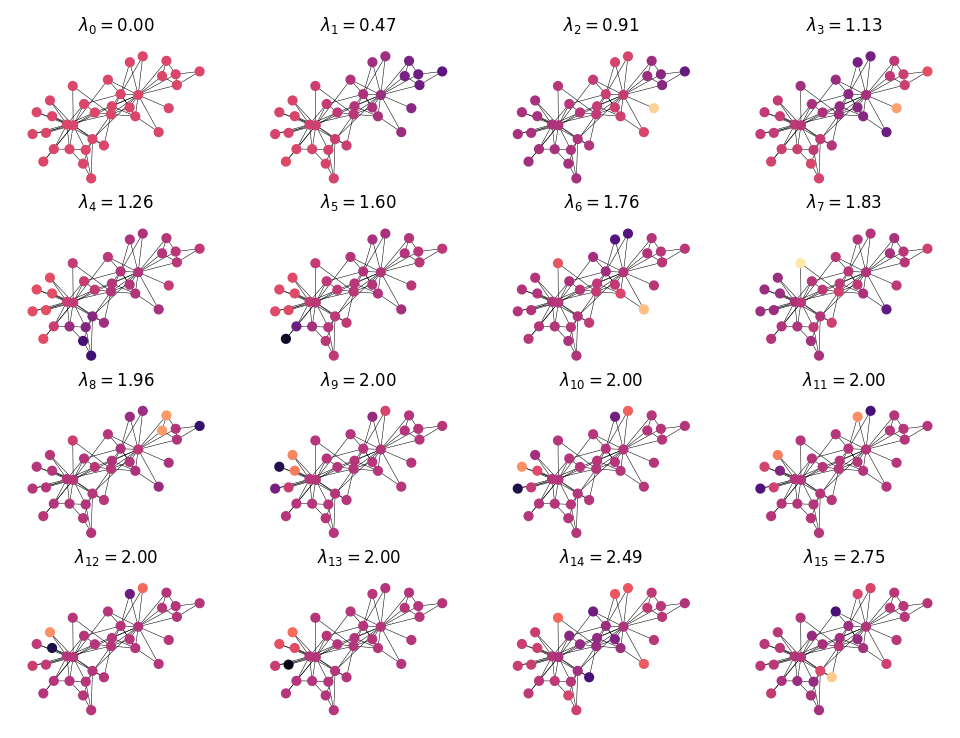

In [16]:
#@title ##### Visualization 

# Plot Fourier basis
fig, ax = plt.subplots(4, 4, figsize=(8,6), dpi=150)
ax = ax.reshape(-1)
vmin, vmax = np.min(Phi), np.max(Phi)
for i in range(len(ax)):
    nc = Phi[:,i]
    nx.draw_networkx(G, pos, node_color=nc, with_labels=False, node_size=15, ax=ax[i], width=0.25, cmap=plt.cm.magma, vmin=vmin, vmax=vmax)
    ax[i].axis('off')
    ax[i].set_title(rf'$\lambda_{{{i}}}={w[i]:.2f}$',fontdict=dict(fontsize=8))

##### Normalized graph Laplacian

Following the paper, we will use a normalized flavour of the Laplacian, defined as follows:

$$
\mathbf{\Delta} = \mathbf{D}^{-1/2}\tilde{\mathbf{A}}\mathbf{D}^{-1/2}.
$$

Where:
- $\tilde{\mathbf{A}}=\mathbf{A}+\mathbf{I}$
- $\mathbf{A}$ is the adjacency matrix 
- $\mathbf{D}$ is the degree matrix.

Intuitivelly: $\Delta$ is the adjacency matrix with enforced self-loops, normalized by the geometric mean of the degrees of the two nodes:
$$
\Delta_{ij} = \frac{\tilde{A}_{ij}}{\sqrt{D_{ii} D_{jj}}}.
$$

The self-loops allow the output features of a node to also depend on its input features, not just on its neighbors. Without the self-loop each node would consider its neighbours' features, but not its own!

In [17]:
# Adjacency matrix
A = nx.adjacency_matrix(G, weight=None)
A = np.array(A.todense())
I = np.eye(A.shape[0])
A = A + I

# Degree matrix (only the diagonal)
dii = np.sum(A, axis=1, keepdims=False)
#D = np.diag(dii)

# Normalized Laplacian
D_inv_h = np.diag(dii**(-0.5))
L =  D_inv_h @ A @ D_inv_h

/var/folders/gr/v_6cxqhs7m5d538mpxzczl140000gn/T/ipykernel_80125/3738507393.py:2: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G, weight=None)


-------------------------------------------------------------------------------
#### **Task**
Now understand how to build the GCN model by using a Laplacian as filter.

  - What would our matrices $Z$ (feature maps) and $W$ (weights) represent?  
-------------------------------------------------------------------------------

#### Model

In the paper (see above) the authors choose to use $\tau_\alpha(\lambda_i) = \sum_{k=1}^{q}\alpha_k\lambda_i^k \;$, thus the convolutional filter $\mathbf{W}$ becomes:

$$
\begin{align}
\mathbf{W} = \mathbf{\Phi}\mathbf{\hat W}\mathbf{\Phi}^\top
&= 
\mathbf{\Phi}
\begin{pmatrix}
\sum_{k=1}^{q}\alpha_k\lambda_1^k &  &  \\
 & \ddots &  \\
 &  & \sum_{k=1}^{q}\alpha_k\lambda_n^k \\
\end{pmatrix}
\mathbf{\Phi}^\top
=
\sum_{k=1}^{q}\alpha_k
\mathbf{\Phi}
\begin{pmatrix}
\lambda_1^k &  &  \\
 & \ddots &  \\
 &  & \lambda_n^k \\
\end{pmatrix}
\mathbf{\Phi}^\top \\
&=  \sum_{k=1}^{q}\alpha_k \mathbf{\Phi} \mathbf{\Lambda}^k \mathbf{\Phi}^\top
= \sum_{k=1}^{q}\alpha_k \mathbf{\Delta}^k.
\end{align} 
$$

With this choice of $\tau_\alpha$ it is not necessary to compute the eigendecomposition of the Laplacian $\mathbf{\Phi}\mathbf{\Lambda}\mathbf{\Phi}^\top$, we can use directly the $k$-powers of $\mathbf{\Delta}$.

Our model will have two GCN layers.
Each layer takes a tensor containing $C_\text{in}$ features for each node,
and returns a tensor containing $C_\text{out}$ features.

In [18]:
import torch.nn as nn
from typing import List

class GCNLayer(nn.Module):
    def __init__(self, 
                 graph_L: torch.Tensor, 
                 in_features: int, 
                 out_features: int, 
                 max_deg: int = 1
        ):
        """
        :param graph_L: the normalized graph laplacian. It is all the information we need to know about the graph
        :param in_features: the number of input features for each node
        :param out_features: the number of output features for each node
        :param max_deg: how many power of the laplacian to consider, i.e. the q in the spacial formula
        """
        super().__init__()
        
        # Each FC is like the alpha_k matrix, with the last one including bias
        self.fc_layers = nn.ModuleList()
        for i in range(max_deg - 1):
            self.fc_layers.append(nn.Linear(in_features, out_features, bias=False))     # q - 1 layers without bias
        self.fc_layers.append(nn.Linear(in_features, out_features, bias=True))          # last one with bias
        
        # Pre-calculate beta_k(L) for every key
        self.laplacians = self.calc_laplacian_functions(graph_L, max_deg)
        
    def calc_laplacian_functions(self, 
                                 L: torch.Tensor, 
                                 max_deg: int
        ) -> List[torch.Tensor]:
        """
        Compute all the powers of L from 1 to max_deg

        :param L: a square matrix
        :param max_deg: number of powers to compute

        :returns: a list of tensors, where the element i is L^{i+1} (i.e. start counting from 1)
        """
        res = [L]
        for _ in range(max_deg-1):
            res.append(torch.mm(res[-1], L))
        return res
        
    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """
        Perform one forward step of graph convolution

        :params X: input features maps [vertices, in_features]
        :returns: output features maps [vertices, out_features]
        """
        Z = torch.tensor(0.)
        for k, fc in enumerate(self.fc_layers):
            L = self.laplacians[k]
            LX = torch.mm(L, X)
            Z = fc(LX) + Z
        
        return torch.relu(Z)

#### **Optional expert tasks: bug in sight!**

If you try to serialize (e.g. save on disk) a trained instance of the previous model with `torch.save`, and then load it again with `torch.load`... it will not work. 

* Can you see why? How would you solve this problem?



In [19]:
#@title ##### Solution 👀

# The laplacians are not saved!
# Check out the Buffers in pytorch to save them:
# https://pytorch.org/docs/stable/nn.html?highlight=register_buffer#torch.nn.Module.register_buffer

In [20]:
in_features, out_features = X.shape[1], 2
graph_L = torch.tensor(L, dtype=torch.float)
max_deg = 2
hidden_dim = 5

# Stack two GCN layers as our model
gcn2 = nn.Sequential(
    GCNLayer(graph_L, in_features, hidden_dim, max_deg),
    GCNLayer(graph_L, hidden_dim, out_features, max_deg),
    nn.LogSoftmax(dim=1)
)
gcn2

Sequential(
  (0): GCNLayer(
    (fc_layers): ModuleList(
      (0): Linear(in_features=34, out_features=5, bias=False)
      (1): Linear(in_features=34, out_features=5, bias=True)
    )
  )
  (1): GCNLayer(
    (fc_layers): ModuleList(
      (0): Linear(in_features=5, out_features=2, bias=False)
      (1): Linear(in_features=5, out_features=2, bias=True)
    )
  )
  (2): LogSoftmax(dim=1)
)

#### Training

We'll train a simple classification task, with the nuance that only the Instructor and Administrator labels are used.

In [21]:
import torch.nn.functional as F
import torch.optim

def train_node_classifier(model, optimizer, X, y, epochs=60, print_every=10):
    y_pred_epochs = []
    for epoch in range(epochs+1):
        y_pred = model(X)  # Compute on all the graph
        y_pred_epochs.append(y_pred.detach())

        # Semi-supervised: only use labels of the Instructor and Admin nodes
        labelled_idx = [ID_ADMIN, ID_INSTR]
        loss = F.nll_loss(y_pred[labelled_idx], y[labelled_idx])  # loss on only two nodes

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % print_every == 0:
            print(f'Epoch {epoch:2d}, loss={loss.item():.5f}')
    return y_pred_epochs

In [22]:
optimizer = torch.optim.Adam(gcn2.parameters(), lr=0.01)

y_pred_epochs = train_node_classifier(gcn2, optimizer, X, labels)

Epoch  0, loss=0.69290
Epoch 10, loss=0.56610
Epoch 20, loss=0.42837
Epoch 30, loss=0.28857
Epoch 40, loss=0.17522
Epoch 50, loss=0.09709
Epoch 60, loss=0.05082


Since our loss is calculated based on two samples only, it's not a good criterion of overall classification accuracy.

Let's look at the the accuracy over all nodes:

In [23]:
y_pred = torch.argmax(gcn2(X), dim=1).detach().numpy()
y = labels.numpy()
print(classification_report(y, y_pred, target_names=['I','A']))

              precision    recall  f1-score   support

           I       1.00      0.88      0.94        17
           A       0.89      1.00      0.94        17

    accuracy                           0.94        34
   macro avg       0.95      0.94      0.94        34
weighted avg       0.95      0.94      0.94        34



#### Compare with MLP

Lets see what we get when we use a regular MLP on the same task.

Remember, we're only training using 2/34 labeled samples.

In [24]:
mlp = nn.Sequential(
    nn.Linear(in_features, hidden_dim),
    nn.ReLU(),
    nn.Linear(hidden_dim, out_features),
    nn.ReLU(),
    nn.LogSoftmax(dim=1)
)

optimizer = torch.optim.Adam(mlp.parameters(), lr=0.01)
_ = train_node_classifier(mlp, optimizer, X, labels, epochs=2000, print_every=500)

print(classification_report(labels.numpy(), torch.argmax(mlp(X), dim=1).detach().numpy(), target_names=['I','A']))

Epoch  0, loss=0.69642
Epoch 500, loss=0.34689
Epoch 1000, loss=0.34668
Epoch 1500, loss=0.34661
Epoch 2000, loss=0.34659
              precision    recall  f1-score   support

           I       0.50      1.00      0.67        17
           A       0.00      0.00      0.00        17

    accuracy                           0.50        34
   macro avg       0.25      0.50      0.33        34
weighted avg       0.25      0.50      0.33        34



/Users/martinholst/miniconda3/envs/AML/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/martinholst/miniconda3/envs/AML/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/martinholst/miniconda3/envs/AML/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

-------------------------------------------------------------------------------
#### **Task**
As expected, the MLP can't learn much about the nodes that we didn't train on.

  - Why was the GCN able to achieve this? 

   *Hint:* Recall that due to the multiplication with the Laplacian, the node embeddings calculated by the GCN at each layer combine the previous layer features from neighbouring nodes.

   When we back-propagated from our two labelled nodes, we also updated the model parameters to produce more meaningful embedding for their neighbours!  

-------------------------------------------------------------------------------

#### Visualization

In [25]:
# @title ##### Visualization - Ignore the methods in this section. The code is not necessary to unterstand for the tasks. They are just used for some nicer visualisations.

import matplotlib.animation as animation
from IPython.display import HTML
import math
def animate_classification(G, y_pred_epochs):
    fig, ax = plt.subplots(figsize=(8, 6), dpi=150)
    
    def draw(epoch_idx):
        pos = {}
        colors, sizes = [],[]
        for v in range(G.number_of_nodes()):
            pos[v] = y_pred_epochs[epoch_idx][v].numpy()
            y_pred_v = np.argmax(pos[v])
            y_v = labels[v]
            if y_pred_v == y_v: colors.append(y_v)
            else: colors.append(0.4) # wrong prediction
            sizes.append((math.exp(pos[v][y_v]))*300) # size is proba of correct label
        ax.cla()
        ax.set_title(f'Epoch {epoch_idx}')
        ax.set_xlabel('Log Softmax Score 1')
        ax.set_ylabel('Log Softmax Score 2')
        nx.draw_networkx(G, 
                         pos, 
                         node_color=colors, 
                         labels=node_labels, 
                         ax=ax, 
                         cmap=cmap, 
                         node_size=sizes, 
                         width=0.1)

    anim = animation.FuncAnimation(fig, draw, frames=len(y_pred_epochs), interval=150)
    html = HTML(anim.to_html5_video())
    plt.close()
    return html

In [26]:
# The coordinates are the log_softmax scores
animate_classification(G, y_pred_epochs)

### **Credits**

- Deep Learning & Applied AI @Sapienza Course material byEmanuele Rodolà, Luca Moschella, and Antonio Norelli - [Original sources](https://erodola.github.io/DLAI-s2-2021/)
- Geometric deep learning [tutorial](https://vistalab-technion.github.io/cs236781/tutorials/tutorial_09/)
- Kipf T, Welling M. Semi-Supervised Classification with Graph Convolutional Networks (2016).
- Bronstein M. M., et al. (2017) Geometric Deep Learning: Going beyond Euclidean data. IEEE Signal Process Mag 34(4).